In [134]:

import torch
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import re
import openai
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [135]:
# Load trained model
model_path = "roberta_fakenews_model"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Cleaning Functions

In [136]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

@torch.no_grad()
def classify_with_roberta(text):
    cleaned = clean_text(text)
    inputs = tokenizer(cleaned, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1).squeeze().tolist()
    label = torch.argmax(logits, dim=1).item()  # → 0 or 1
    y_score = probs[1]
    return label, y_score

def classify_claim(claim_text, model="gpt-4-turbo"):
    """Calls OpenAI API to classify a claim as SUPPORTS or REFUTES."""
    if not isinstance(claim_text, str) or claim_text.strip() == "":
        return None

    prompt = f"""
    Determine whether the following claim is "SUPPORTS" or "REFUTES".
    Provide only 0 if "SUPPORTS" or 1 if "REFUTES" as the output.

    Claim:
    {claim_text}
    """

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a fact-checking AI."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )

        prediction = response.choices[0].message.content.strip()
        return prediction if prediction in ["1", "0"] else None

    except Exception as e:
        print(f"LLM Error: {e}")
        return None


def classify_with_llm(text):
    result = classify_claim(text)
    if result == "0":
        return 0  # SUPPORTS → Real
    elif result == "1":
        return 1  # REFUTES → Fake
    else:
        return "Unable to determine"  # Uncertain

## Domain-Aware Routing (Hard Split)

In [ ]:
def detect_domain_by_length(text, threshold=65):
    return "reuters" if len(text.split()) > threshold else "fever"

def ensemble_router(text):
    domain = detect_domain_by_length(text)

    if domain == "reuters":
        label, score = classify_with_roberta(text)
    elif domain == "fever":
        label = classify_with_llm(text)
        score = float(label)
    else:
        raise ValueError("Invalid input")

    return label,score, domain  # 0 = Real, 1 = Fake

In [138]:
# Load data
true_df = pd.read_csv("../data/True.csv")
false_df = pd.read_csv("../data/Fake.csv")
fever_df = pd.read_excel("../data/filtered_fever_data.xlsx")

# Add labels
true_df["label"] = 0
false_df["label"] = 1

# Standardize fever labels
fever_df["label"] = fever_df["label"].map({"SUPPORTS": 0, "REFUTES": 1})

# Clean and unify columns
true_df["text"] = true_df["title"] + " " + true_df["text"]
false_df["text"] = false_df["title"] + " " + false_df["text"]

# Select and unify necessary columns
true_df = true_df[["text", "label"]]
false_df = false_df[["text", "label"]]
fever_df = fever_df[["claim", "label"]].rename(columns={"claim": "text"})

# Combine all datasets
merged_df = pd.concat([true_df, false_df, fever_df], ignore_index=True)
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [139]:
# Limit to first 300 rows
merged_df = merged_df.iloc[:1000]

# Run through ensemble
predictions = []
scores = []
domains = []

for text in merged_df["text"]:
    pred, score, domain = ensemble_router(text)
    predictions.append(pred)
    scores.append(score)
    domains.append(domain)

In [140]:
merged_df["predicted"] = predictions
merged_df["domain"] = domains

excel_path = "ensemble_predictions.xlsx"
merged_df.to_excel(excel_path, index=False)
print(f"Saved predictions to {excel_path}")

Saved predictions to ensemble_predictions.xlsx


In [141]:
merged_df

,text,label,predicted,domain
0,Kingdom of Hearts III won't be playable on two...,1,1,fever
1,Slovakia is peaceful.,0,1,fever
2,House Republican offers bill to keep governmen...,0,0,reuters
3,All the president's women: Duterte's fiercest ...,0,0,reuters
4,Tony Bill directed a film based on a book.,0,1,fever
...,...,...,...,...
995,British Columbia includes Vancouver Island.,0,0,fever
996,David Bowie's final album was released two day...,0,1,fever
997,Illinois House opts for another stopgap budget...,0,0,reuters
998,UK to remain in sync after Brexit with EU rule...,0,0,reuters


In [151]:
# Split by domain
fever_df = merged_df[merged_df["domain"] == "fever"]
reuters_df = merged_df[merged_df["domain"] == "reuters"]

# Confusion for FEVER
fever_cm = confusion_matrix(fever_df["label"], fever_df["predicted"])
fever_cm_df = pd.DataFrame(fever_cm, index=["Actual Fake", "Actual Real"], columns=["Pred Fake", "Pred Real"])
print("\nFEVER Confusion Matrix:")
print(fever_cm_df)

# Confusion for REUTERS
reuters_cm = confusion_matrix(reuters_df["label"], reuters_df["predicted"])
reuters_cm_df = pd.DataFrame(reuters_cm, index=["Actual Fake", "Actual Real"], columns=["Pred Fake", "Pred Real"])
print("\nREUTERS Confusion Matrix:")
print(reuters_cm_df)



FEVER Confusion Matrix:
             Pred Fake  Pred Real
Actual Fake        339        197
Actual Real          4        181

REUTERS Confusion Matrix:
             Pred Fake  Pred Real
Actual Fake        130          1
Actual Real          0        148


In [150]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

accuracy = round(accuracy_score(y_true, y_pred), 5)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_true, y_pred, digits=5))

print("EDA and Fake News Classification completed successfully!")

Accuracy: 0.798
Classification Report:
              precision    recall  f1-score   support

           0    0.99154   0.70315   0.82281       667
           1    0.62429   0.98799   0.76512       333

    accuracy                        0.79800      1000
   macro avg    0.80792   0.84557   0.79396      1000
weighted avg    0.86925   0.79800   0.80360      1000

EDA and Fake News Classification completed successfully!


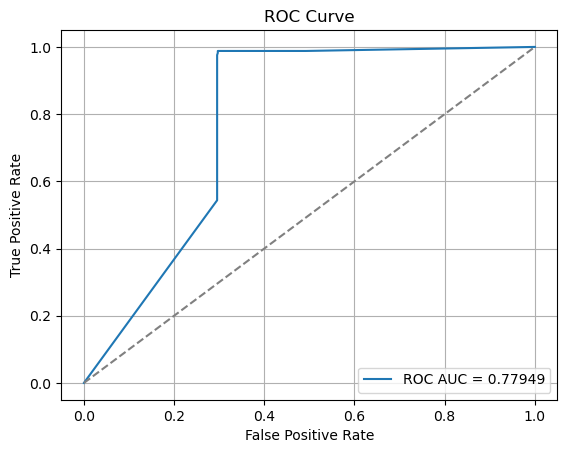

In [152]:
y_true = merged_df["label"].tolist()
y_scores = [s[0] if isinstance(s, list) else s for s in scores]  # handles both [p_fake, p_real] and float

# Compute ROC AUC
roc_auc = roc_auc_score(y_true, y_scores)
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.5f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()
